In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
path = '/content/drive/MyDrive/עבודה בינה מלאכותית/data_base'

directories = [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]

print(directories)

['nonpd', 'pd', 'Prodromal', 'תמונות תסמינים שלא השתמשנו בהם לפיתוח מודל בגלל עודף']


In [ ]:
import os
import pandas as pd
import random

# נתיב לתקיות החולים והלא חולים

path = r'/content/drive/MyDrive/עבודה בינה מלאכותית/data_base'
patients_dir = path + r'/Prodromal'
healthy_dir = path + r'/nonpd'



healthy_df =  pd.read_csv(path + r'/Healthy_list_for_model_3,4.csv')

# יצירת רשימות של התמונות והלייבלים
images = []
labels = []

# הוספת תמונות חולים
for filename in os.listdir(patients_dir):
    images.append(os.path.join(patients_dir, filename))
    labels.append('Prodromal')

random.seed(25)
random.shuffle(images)

images = images[:healthy_df.shape[0]]
labels = labels[:len(images)]


# הוספת תמונות לא חולים
for _, row in healthy_df.iterrows():
    filename = str(row['File Name'])
    images.append(os.path.join(healthy_dir, filename))
    labels.append('NONPD')

# צעד 3: יצירת דאטה פריים
df = pd.DataFrame({
    'Image': images,
    'Label': labels
})



print(f'prodromal - nonpd ratio -> {df[df["Label"] == "Prodromal"].shape[0]//df[df["Label"] == "NONPD"].shape[0] }:1')


# הצגת הדאטה פריים
df.head()

prodromal - nonpd ratio -> 1:1


,Image,Label
0,/content/drive/MyDrive/עבודה בינה מלאכותית/dat...,Prodromal
1,/content/drive/MyDrive/עבודה בינה מלאכותית/dat...,Prodromal
2,/content/drive/MyDrive/עבודה בינה מלאכותית/dat...,Prodromal
3,/content/drive/MyDrive/עבודה בינה מלאכותית/dat...,Prodromal
4,/content/drive/MyDrive/עבודה בינה מלאכותית/dat...,Prodromal


In [ ]:
def img_to_array(iterable):
    arr = np.asarray(iterable, dtype=np.float32) / 255.0
    return arr

In [ ]:
import cv2
import numpy as np
from tensorflow.keras.utils import to_categorical


def load_images_from_df(df):
    images = []
    labels = []

    for index, row in df.iterrows():
        image = cv2.imread(row['Image'])
        if (index + 1) % 100 == 0:
            print(f"----- {index + 1} -----")
        image = cv2.resize(image, (224, 224))
        images.append(image)
        labels.append(row['Label'])

    labels = [1 if label == 'Prodromal' else 0 for label in labels]
    labels = to_categorical(labels)
    return images, labels


images = []
labels = []

images, labels = load_images_from_df(df)

----- 100 -----
----- 200 -----
----- 300 -----
----- 400 -----
----- 500 -----
----- 600 -----
----- 700 -----
----- 800 -----


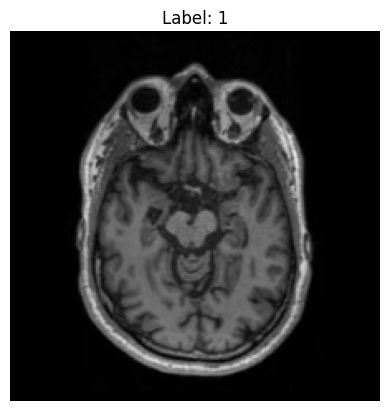

In [ ]:
# מומלץ להריץ
import matplotlib.pyplot as plt
# דוגמה להצגת מטופל לאחר חפרדת הנתונים לחולה ובריא
index = 435  # אינדקס רצוי

# בדיקה שהתמונה קיימת
if index < len(images):
    plt.imshow(img_to_array(images)[index])  # מציג את התמונה
    plt.title(f"Label: {np.argmax(labels[index])}")  # מציג את הליבל של התמונה הספציפית
    plt.axis('off')  # מסרת צירים
    plt.show()
else:
    print(f"The index {index} is out of range. Please choose a valid index.")

In [ ]:
# אסור להריץ ואסור לשנות פרמטרים זה קובע את יציבות הניסוי בחזרה עליו
from sklearn.model_selection import train_test_split

X_temp, X_test, y_temp, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)


print("Training set size:", len(X_train), f" - {round(100 * len(X_train) / df.shape[0], 2)}%")
print("Validation set size:", len(X_val), f" - {round(100 * len(X_val) / df.shape[0], 2)}%")
print("Test set size:", len(X_test), f" - {round(100 * len(X_test) / df.shape[0], 2)}%")
print(f"Total images: {df.shape[0]}")

Training set size: 561  - 63.9%
Validation set size: 141  - 16.06%
Test set size: 176  - 20.05%
Total images: 878


In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras import layers

data_augmentation = Sequential([
    layers.RandomRotation(0.005),       # Apply a small random rotation (0.5%)
    layers.RandomZoom(0.1),             # Apply a small random zoom
    layers.RandomContrast(0.05),        # Apply a slight random contrast adjustment
], name="augmentation_layer")  # Name the layer for easier identification

X_train = data_augmentation(X_train)
X_train = img_to_array(X_train)
X_val = img_to_array(X_val)
X_test = img_to_array(X_test)


In [ ]:
from tensorflow.keras import backend as K

def f1_score(y_true, y_pred):
    # Convert both y_true and y_pred to float32 to prevent data type issues
    y_true = K.cast(y_true, dtype='float32')
    y_pred = K.cast(y_pred, dtype='float32')

    tp = K.sum(K.round(y_true * y_pred))  # Calculate true positives
    predicted_positives = K.sum(K.round(y_pred))  # Calculate predicted positives
    possible_positives  = K.sum(K.round(y_true))  # Calculate possible positives

    precision = tp / (predicted_positives + K.epsilon())  # Calculate precision
    recall    = tp / (possible_positives + K.epsilon())   # Calculate recall

    # Return the F1 score: harmonic mean of precision and recall
    return 2 * (precision * recall) / (precision + recall + K.epsilon())

In [ ]:
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Dense, Dropout

# נתיב המודל שלך
model_path = '/content/drive/MyDrive/עבודה בינה מלאכותית/output_models/(1)/First_model_convolutional_network.h5'

# טוען את המודל עם compile=False כדי לא להפעיל חישובים מיותרים
base_model = load_model(model_path, compile=False)

# סיכום המודל כדי לוודא שהוא טוען נכון
base_model.summary()

# אם המודל הוא מסוג Sequential, נשתמש בקלט שלו באופן ישיר
input_layer = base_model.layers[0].input  # כאן אנחנו לוקחים את השכבה הראשונה כקלט

# הקפאת כל השכבות במודל הבסיסי
for layer in base_model.layers:
    layer.trainable = False

# גישה לפלט אחרי ה-Flatten
x = base_model.get_layer('flatten').output

# בניית שכבות Dense חדשות
x = Dense(256, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu')(x)
x = Dense(2, activation='softmax')(x)

# יצירת המודל החדש על ידי חיבור מחדש של הקלט והפלט
new_model = Model(inputs=input_layer, outputs=x)

# קומפילציה מחדש של המודל עם פונקציית הפסד ומטריקות
new_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'precision', 'recall'])

# הצגת סיכום המודל החדש
new_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 54, 54, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,169,474 (42.61 MB)

 Trainable params: 11,169,346 (42.61 MB)

 Non-trainable params: 128 (512.00 B)

Model: "functional_414"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 54, 54, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_36 (Dense)                     │ (None, 256)                 │      22,151,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_37 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_38 (Dense)                     │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,278,082 (84.98 MB)

 Trainable params: 22,184,578 (84.63 MB)

 Non-trainable params: 93,504 (365.25 KB)

In [ ]:
from tensorflow.keras.callbacks import Callback

class HistoryCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs is not None:
            epoch_data = {
                'epoch': epoch + 1,
                'accuracy': logs.get('accuracy'),
                'loss': logs.get('loss'),
                'val_accuracy': logs.get('val_accuracy'),
                'val_loss': logs.get('val_loss'),
                'precision': logs.get('precision'),
                'recall': logs.get('recall'),
            }
            self.df_history = pd.concat([self.df_history, pd.DataFrame([epoch_data])], ignore_index=True)


    def __init__(self, path):
        super(HistoryCallback, self).__init__()
        self.path = path
        self.df_history = pd.DataFrame(columns=[
            'epoch', 'accuracy', 'loss', 'val_accuracy', 'val_loss', 'precision', 'recall'])

    def on_train_end(self, logs=None):
        self.df_history['f1-score'] = self.df_history.apply(
        lambda row: 2 * (row['precision'] * row['recall']) / (row['precision'] + row['recall'])
         if (row['precision'] + row['recall']) > 0 else 0, axis=1)

        self.df_history.to_csv(self.path + '_training_history(1).csv', index=False)
        print(f"Training history saved to \"{self.path}_training_history(2).csv\"")

In [ ]:
from tensorflow.keras.callbacks import Callback

class EarlyStopCheckpoint(Callback):
    def __init__(self, patience=5, filepath="best_model.h5"):
        super().__init__()
        self.patience = patience  # מספר אפוקים רצופים שאין בהם שיפור
        self.filepath = filepath  # המיקום לשמירת המודל
        self.best_loss = float('inf')  # אתחול לערך אינסופי (לוס הכי גרוע)
        self.wait = 0  # מספר אפוקים בהם לא היה שיפור
        self.stopped_epoch = 0  # מספר האפוק שבו האימון נעצר

    def on_epoch_end(self, epoch, logs=None):
        # אם יש לוגים על הלוס
        current_loss = logs.get('val_loss')  # הערך של הלוס בסט הוולידציה

        if current_loss is not None:
            # אם הלוס השתפר (הפך למינימלי יותר), נשמור את המודל
            if current_loss < self.best_loss:
                self.best_loss = current_loss
                self.wait = 0
                self.model.save(self.filepath)  # שמירת המודל
                print(f"Epoch {epoch+1}: New best model saved with loss {current_loss:.4f}")
            else:
                self.wait += 1

            # אם לא היה שיפור במשך חמישה אפוקים רצופים, נעצור את האימון
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                print(f"Epoch {epoch+1}: Stopping early due to no improvement for {self.patience} epochs.")


In [ ]:
def plot_history(history, path, ep_stop):
    # גרף Loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.axvline(x=ep_stop, color='r', linestyle='--', label='Early Stopping')  # קו אנכי מקוקו
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # גרף Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history['accuracy'], label='Training Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.axvline(x=ep_stop, color='r', linestyle='--', label='Early Stopping')  # קו אנכי מקוקו
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.savefig(path + '_loss_accuracy_plot(2).png')
    plt.show()

In [ ]:
save_path = '/content/drive/MyDrive/עבודה בינה מלאכותית/output_models/(3)/'
history_callback = HistoryCallback(save_path + 'model_2')
early_stop = EarlyStopCheckpoint()
# אימון
history = new_model.fit(
    X_train, y_train,
    epochs=27,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[history_callback,early_stop]
)

Epoch 1/27
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6286 - loss: 0.7571 - precision: 0.6286 - recall: 0.6286

<ipython-input-61-8f3b77f77286>:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.df_history = pd.concat([self.df_history, pd.DataFrame([epoch_data])], ignore_index=True)


Epoch 1: New best model saved with loss 0.4657
18/18 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.6331 - loss: 0.7503 - precision: 0.6331 - recall: 0.6331 - val_accuracy: 0.8014 - val_loss: 0.4657 - val_precision: 0.8014 - val_recall: 0.8014
Epoch 2/27
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8172 - loss: 0.4102 - precision: 0.8172 - recall: 0.8172

Epoch 2: New best model saved with loss 0.3494
18/18 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.8188 - loss: 0.4083 - precision: 0.8188 - recall: 0.8188 - val_accuracy: 0.8652 - val_loss: 0.3494 - val_precision: 0.8652 - val_recall: 0.8652
Epoch 3/27
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9001 - loss: 0.2718 - precision: 0.9001 - recall: 0.9001

Epoch 3: New best model saved with loss 0.3021
18/18 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.9003 - loss: 0.2713 - precision: 0.9003 - recall: 0.9003 - val_accuracy: 0.9007 - val_loss: 0.3021 - val_precision: 0.9007 - val_recall: 0.9007
Epoch 4/27
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9130 - loss: 0.2301 - precision: 0.9130 - recall: 0.9130

Epoch 4: New best model saved with loss 0.2568
18/18 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.9129 - loss: 0.2301 - precision: 0.9129 - recall: 0.9129 - val_accuracy: 0.9433 - val_loss: 0.2568 - val_precision: 0.9433 - val_recall: 0.9433
Epoch 5/27
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9282 - loss: 0.1855 - precision: 0.9282 - recall: 0.9282

Epoch 5: New best model saved with loss 0.2149
18/18 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.9289 - loss: 0.1845 - precision: 0.9289 - recall: 0.9289 - val_accuracy: 0.9504 - val_loss: 0.2149 - val_precision: 0.9504 - val_recall: 0.9504
Epoch 6/27
18/18 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.9322 - loss: 0.1638 - precision: 0.9322 - recall: 0.9322 - val_accuracy: 0.9078 - val_loss: 0.2454 - val_precision: 0.9078 - val_recall: 0.9078
Epoch 7/27
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9433 - loss: 0.1764 - precision: 0.9433 - recall: 0.9433

Epoch 7: New best model saved with loss 0.1964
18/18 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.9430 - loss: 0.1762 - precision: 0.9430 - recall: 0.9430 - val_accuracy: 0.9433 - val_loss: 0.1964 - val_precision: 0.9433 - val_recall: 0.9433
Epoch 8/27
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9302 - loss: 0.1516 - precision: 0.9302 - recall: 0.9302

Epoch 8: New best model saved with loss 0.1902
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.9294 - loss: 0.1535 - precision: 0.9294 - recall: 0.9294 - val_accuracy: 0.9362 - val_loss: 0.1902 - val_precision: 0.9362 - val_recall: 0.9362
Epoch 9/27
18/18 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.9006 - loss: 0.1999 - precision: 0.9006 - recall: 0.9006 - val_accuracy: 0.9433 - val_loss: 0.1993 - val_precision: 0.9433 - val_recall: 0.9433
Epoch 10/27
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9658 - loss: 0.0893 - precision: 0.9658 - recall: 0.9658

Epoch 10: New best model saved with loss 0.1754
18/18 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.9658 - loss: 0.0892 - precision: 0.9658 - recall: 0.9658 - val_accuracy: 0.9362 - val_loss: 0.1754 - val_precision: 0.9362 - val_recall: 0.9362
Epoch 11/27
18/18 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.9674 - loss: 0.0853 - precision: 0.9674 - recall: 0.9674 - val_accuracy: 0.9220 - val_loss: 0.1853 - val_precision: 0.9220 - val_recall: 0.9220
Epoch 12/27
18/18 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.9827 - loss: 0.0638 - precision: 0.9827 - recall: 0.9827 - val_accuracy: 0.9149 - val_loss: 0.1763 - val_precision: 0.9149 - val_recall: 0.9149
Epoch 13/27
18/18 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.9592 - loss: 0.0834 - precision: 0.9592 - recall: 0.9592 - val_accuracy: 0.9078 - val_loss: 0.2640 - val_precision: 0.9078 - val_recall: 0.9078
Epoch 14/27
18/18 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.9817 - loss: 0.0703 - precision: 0.9817 - recall: 0.9817 - val_

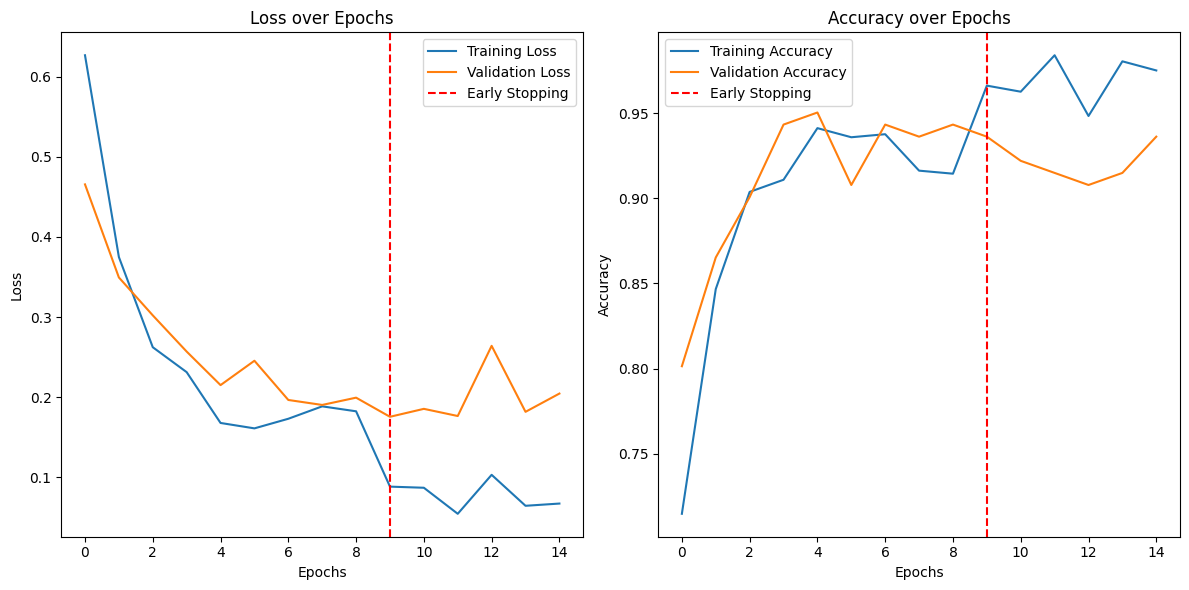

In [ ]:
plot_history(history_callback.df_history.loc[:, ['accuracy', 'val_accuracy', 'loss', 'val_loss']], save_path + 'model_3', 14-5)

In [ ]:
# מומלץ להריץ
# הערכת המודל
from tensorflow.keras.models import load_model
best_model = load_model('best_model.h5')
test_results = best_model.evaluate(X_test, y_test)
test_loss, test_acc = test_results[0], test_results[1]
print(f'Loss: {round(test_loss, 6)}, Accuracy: {round(test_acc * 100, 3)}%')

6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 870ms/step - accuracy: 0.9301 - loss: 0.1891 - precision_33: 0.9301 - recall_33: 0.9301
Loss: 0.197633, Accuracy: 93.182%


In [ ]:
# מומלץ להריץ
# בחינת מודל עבור כל קבוצת הבחינה
predictions = np.argmax(best_model.predict(X_test), axis=1)
print("test len:" + str(len(X_test)))
accuracy_checker = 0
for i in range(len(X_test)):
    print('Image %d => Predicted: %d (expected %d)' % (i, predictions[i], np.argmax(y_test[i])))
    if predictions[i] == np.argmax(y_test[i]):
      accuracy_checker += 1
print(f'Accuracy: {accuracy_checker/len(X_test)}')


6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step
test len:176
Image 0 => Predicted: 1 (expected 1)
Image 1 => Predicted: 1 (expected 1)
Image 2 => Predicted: 0 (expected 0)
Image 3 => Predicted: 1 (expected 1)
Image 4 => Predicted: 1 (expected 1)
Image 5 => Predicted: 0 (expected 0)
Image 6 => Predicted: 0 (expected 0)
Image 7 => Predicted: 0 (expected 0)
Image 8 => Predicted: 0 (expected 0)
Image 9 => Predicted: 1 (expected 1)
Image 10 => Predicted: 1 (expected 1)
Image 11 => Predicted: 0 (expected 0)
Image 12 => Predicted: 0 (expected 0)
Image 13 => Predicted: 1 (expected 1)
Image 14 => Predicted: 0 (expected 0)
Image 15 => Predicted: 0 (expected 1)
Image 16 => Predicted: 0 (expected 0)
Image 17 => Predicted: 1 (expected 1)
Image 18 => Predicted: 1 (expected 1)
Image 19 => Predicted: 0 (expected 0)
Image 20 => Predicted: 0 (expected 0)
Image 21 => Predicted: 0 (expected 1)
Image 22 => Predicted: 0 (expected 0)
Image 23 => Predicted: 1 (expected 1)
Image 24 => Predicted: 1 (expected 1)
Image 25 =>

6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step


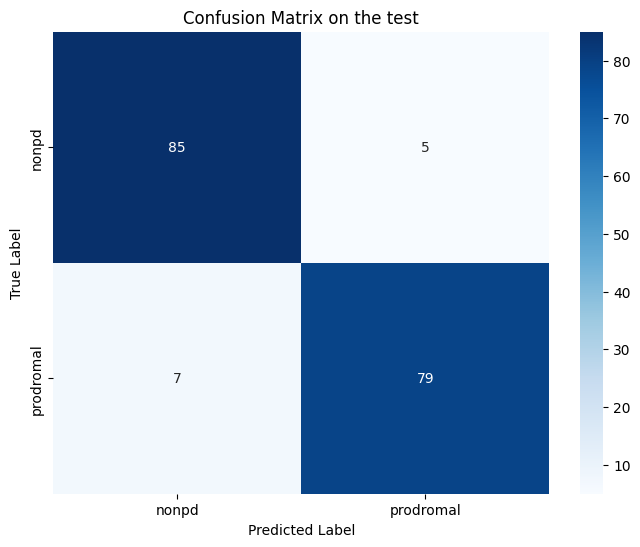

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
# Get predictions
y_pred_prob = best_model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
class_names = ["nonpd", "prodromal"]
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix on the test")
plt.show()


In [ ]:
# שמירת המודל והמשקולות
best_model.save ( save_path +  'Third_model_Transfer_Learning_on_Convolutional_Network.keras' )
best_model.save ( save_path +  'Third_model_Transfer_Learning_on_Convolutional_Network.h5' )
best_model.save_weights ( save_path +  'Third_model_Transfer_Learning_on_Convolutional_Network_weight.weights.h5')